In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('daily-website-visitors.csv', thousands=',')

In [3]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236


In [6]:
pd.to_datetime(df["Date"]).min()

Timestamp('2014-09-14 00:00:00')

In [7]:
pd.to_datetime(df["Date"]).max()

Timestamp('2020-08-19 00:00:00')

In [4]:
# Contar valores nulos
print(df.isnull().sum())

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64


In [9]:
df['Date'] = pd.to_datetime(df['Date']).dropna()

El modelo tiene un comportamiento no estacionario ya que tiene una tendencia creciente a lo largo del tiempo. Para solucionar esto, se puede aplicar una transformación logarítmica a los datos.

(2167, 1)

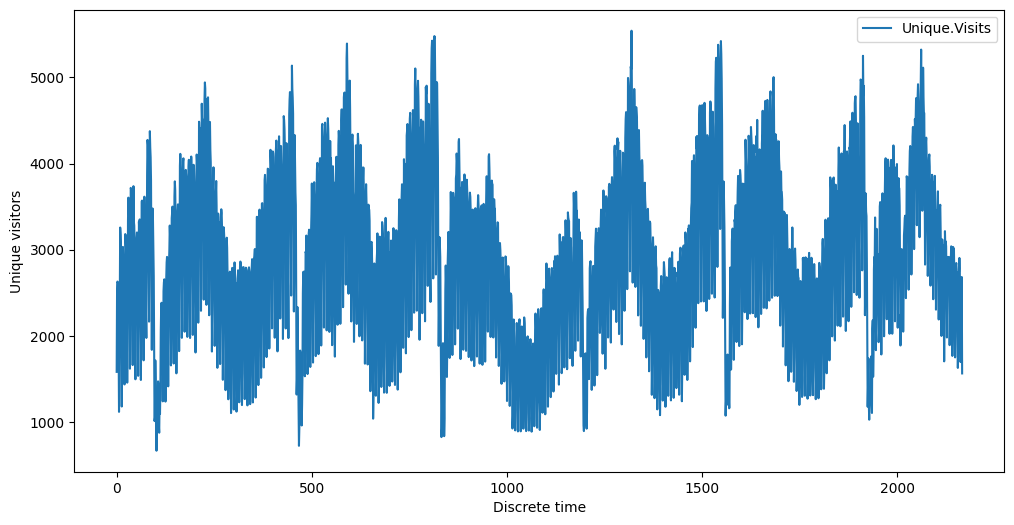

In [10]:
series = pd.DataFrame(data=df['Unique.Visits'], columns = ['Unique.Visits']).dropna()
series.plot(figsize=(12, 6))
plt.ylabel('Unique visitors')
plt.xlabel('Discrete time')
series.shape

Al realizar una prueba formal de estacionariedad (Dickey-Fuller aumentada), se obtiene un p-valor de 0.9989, lo que indica que no se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [11]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Se asegura que la columna Date sea el índice y esté en formato datetime
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Se realiza la prueba ADF sobre la columna Gold_Price
result = adfuller(df['Unique.Visits'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.4759685744454085
p-value: 0.0002172640930007976
Critical Values 1%: -3.4334094211542983
Critical Values 5%: -2.8628915360971003
Critical Values 10%: -2.5674894918770197


Se aplica una diferenciación en los datos para eliminar la tendencia

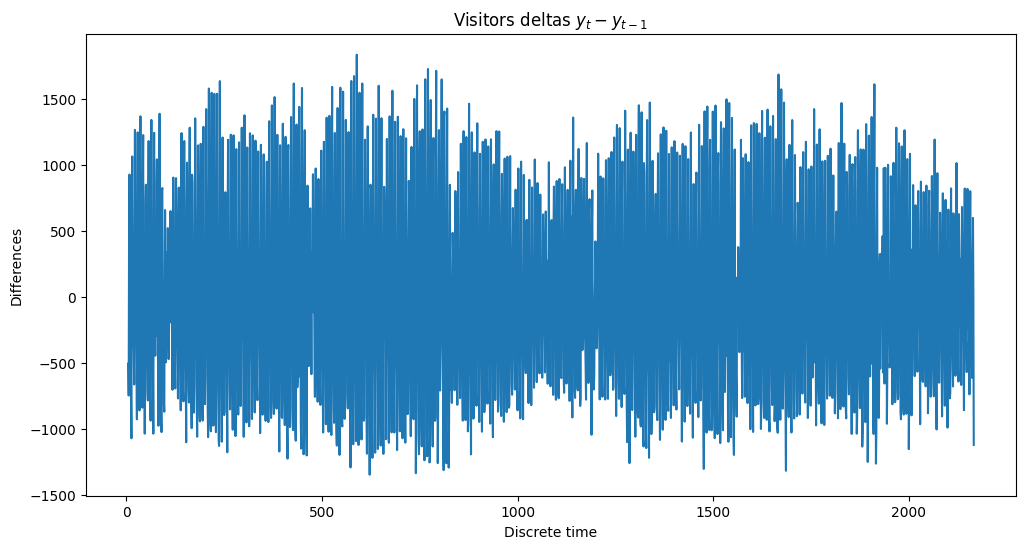

In [14]:
# Se aplica una diferenciación para eliminar la tendencia
df['visitors_diff'] = df['Unique.Visits'].diff().dropna()
# Se grafica la serie diferenciada
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df.index, df['visitors_diff'], label='visitors_diff')
plt.title('Visitors deltas $y_t - y_{t-1}$')
plt.ylabel('Differences')
plt.xlabel('Discrete time')
plt.show()

Al probar la estacionariedad de los datos diferenciados, se obtiene un p-valor de 1.72e-21, lo que indica que se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [13]:
# Prueba ADF en la serie diferenciada
result_diff = adfuller(df['visitors_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -12.129598735255767
p-value: 1.7482961408023245e-22
Critical Values 1%: -3.4334108531807006
Critical Values 5%: -2.862892168387536
Critical Values 10%: -2.5674898285322496


AR(1): R² ajustado = 0.5880179669984968, Error Promedio (MSE) = 610.0146934173209, Error absoluto  (MAE) = 491.62238369311746
AR(1): coeficientes = [0.75013545], intercepto = 720.614864589314
AR(2): R² ajustado = 0.6692268785657339, Error Promedio (MSE) = 546.4682805277922, Error absoluto  (MAE) = 452.08273511935124
AR(2): coeficientes = [ 1.11917729 -0.49296642], intercepto = 1076.0859822426396
AR(3): R² ajustado = 0.719966494426041, Error Promedio (MSE) = 502.69376553029144, Error absoluto  (MAE) = 425.5746990182927
AR(3): coeficientes = [ 1.30076489 -0.90499013  0.36870664], intercepto = 678.9443286453256
AR(4): R² ajustado = 0.7193247812392456, Error Promedio (MSE) = 503.15192181242253, Error absoluto  (MAE) = 424.2202647056187
AR(4): coeficientes = [ 1.32163328 -0.95619571  0.44228084 -0.0566059 ], intercepto = 717.333432609677


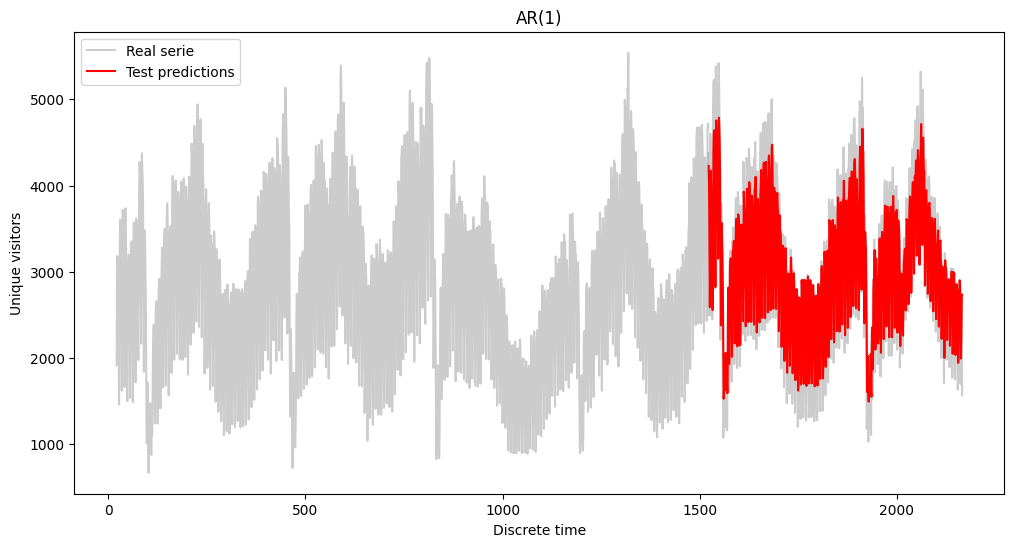

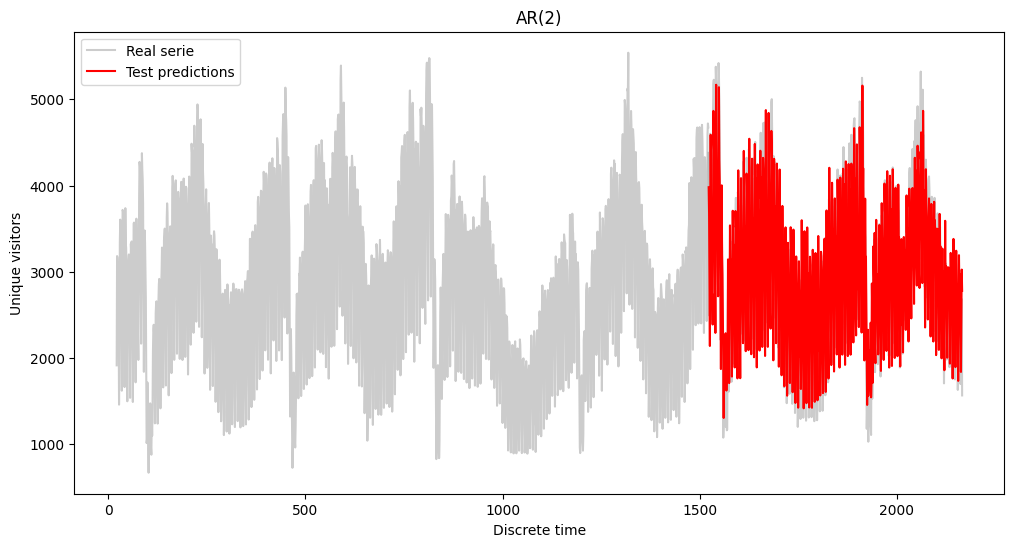

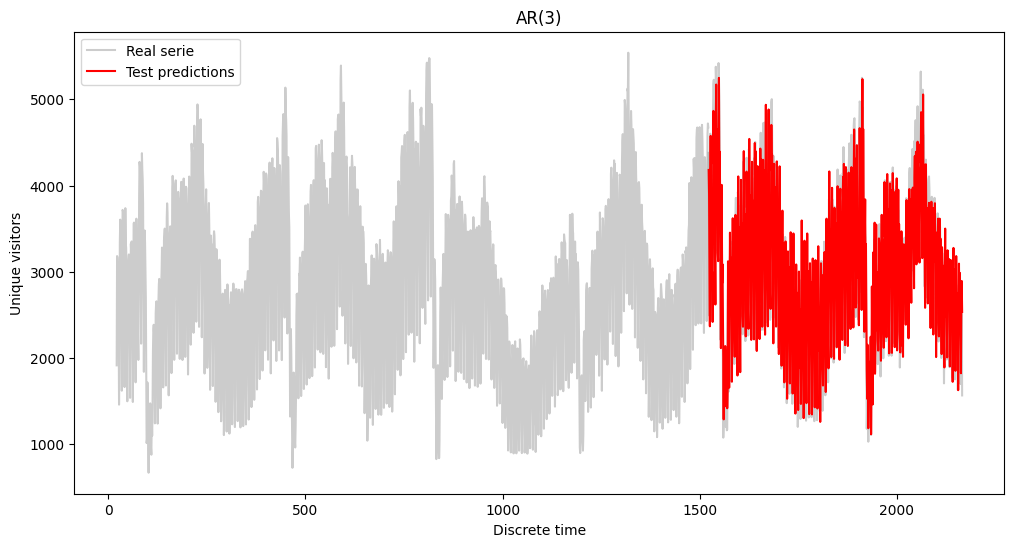

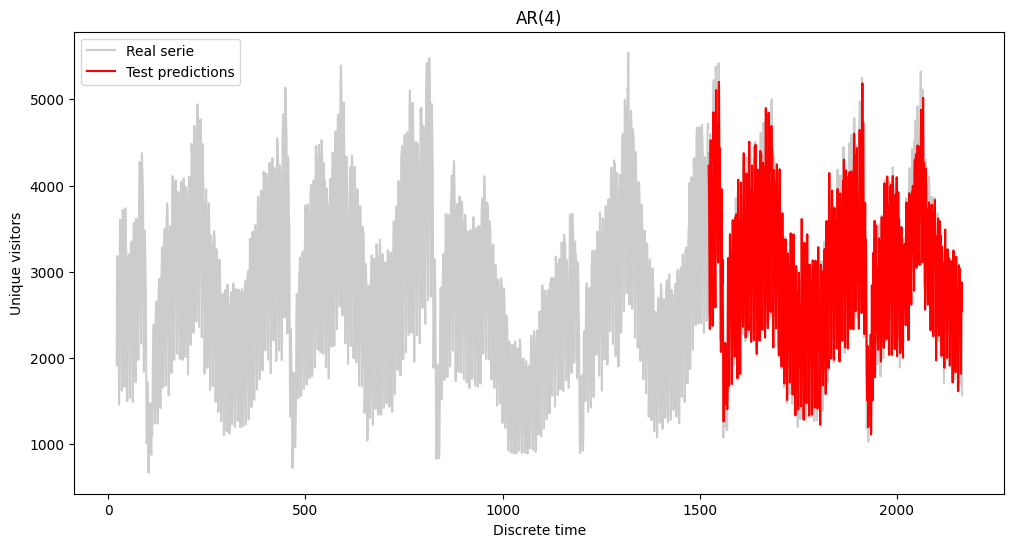

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['Unique.Visits'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['Unique.Visits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    predictions = pd.Series(predictions)
    predictions.index = y_test.index
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'AR({lag}): R² ajustado = {r2_adj}, Error Promedio (MSE) = {mse}, Error absoluto  (MAE) = {mae}')
    print(f'AR({lag}): coeficientes = {model.coef_}, intercepto = {model.intercept_}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, color = 'black', alpha = 0.2, label = "Real serie")
    plt.plot(y_test, color = 'black', alpha = 0.2)
    plt.plot(predictions, color = 'red', alpha = 1, label = "Test predictions")

    plt.ylabel('Unique visitors')
    plt.xlabel('Discrete time')
    plt.title(f"AR({lag})")
    plt.legend()

AR(1): R² ajustado = 0.0872272605810519, Error Promedio (MSE) = 617.0552504847698, Error absoluto  (MAE) = 517.3791071926893
AR(1): coeficientes = [0.30595943], intercepto = 0.6021983365335093
AR(2): R² ajustado = 0.33486425219000726, Error Promedio (MSE) = 526.6188155556872, Error absoluto  (MAE) = 452.59377365761526
AR(2): coeficientes = [ 0.47076923 -0.53869255], intercepto = 0.9891364467729494
AR(3): R² ajustado = 0.33808933483850934, Error Promedio (MSE) = 525.2177255606922, Error absoluto  (MAE) = 451.2349324550642
AR(3): coeficientes = [ 0.43845505 -0.51046264 -0.05996199], intercepto = 1.099889654328745
AR(4): R² ajustado = 0.551697699384233, Error Promedio (MSE) = 432.1391165162416, Error absoluto  (MAE) = 340.59536820711423
AR(4): coeficientes = [ 0.40097844 -0.83091808  0.21505055 -0.62763184], intercepto = 1.7409757849837488


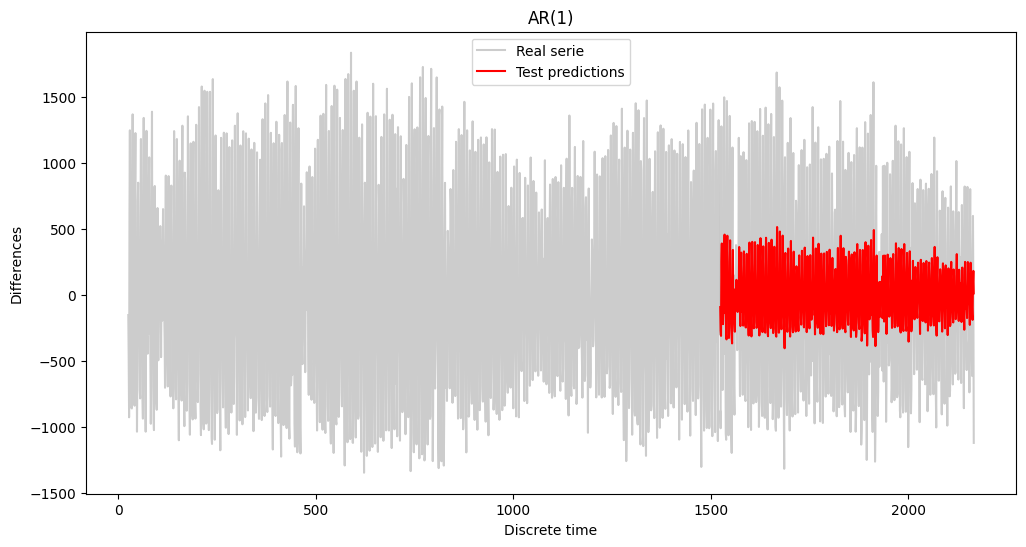

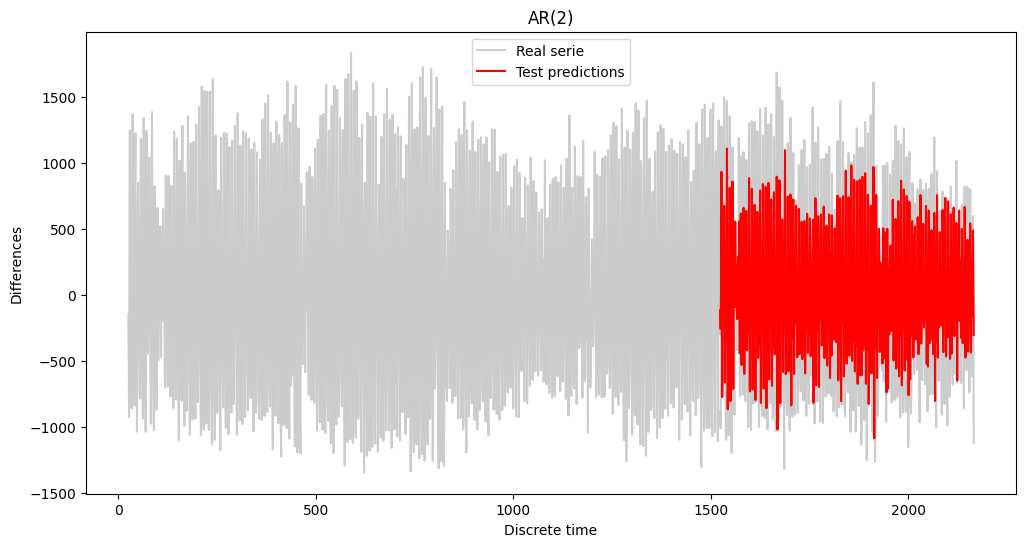

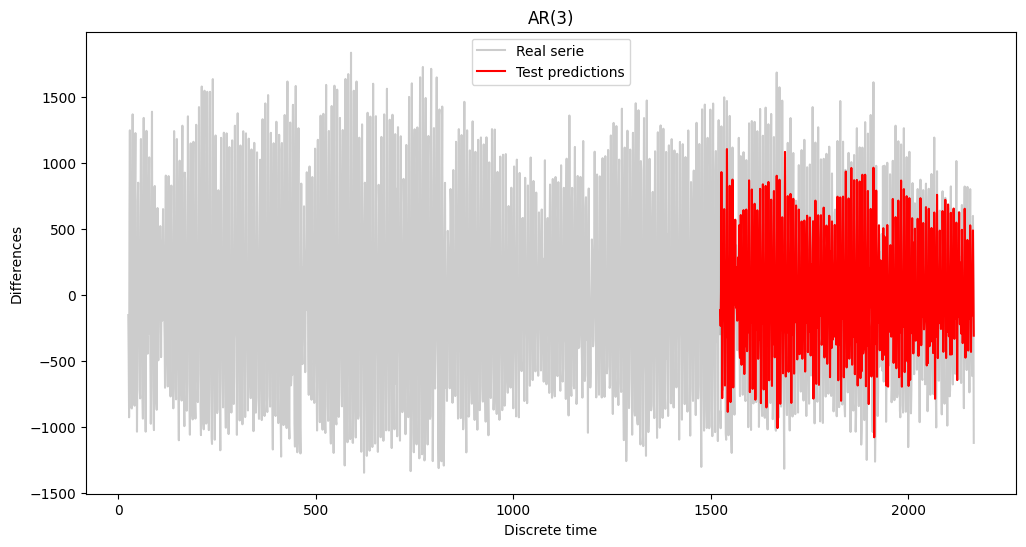

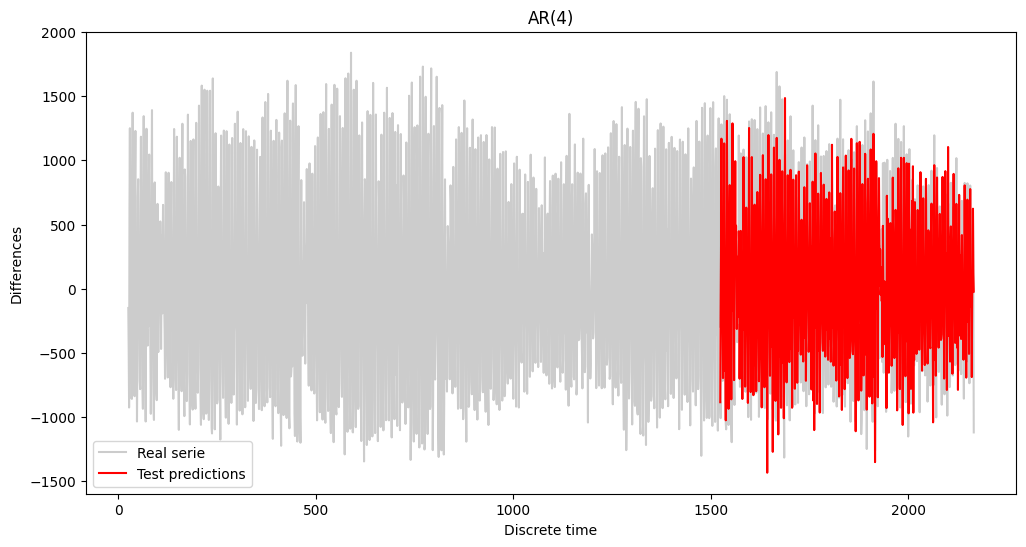

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['visitors_diff'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['visitors_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    predictions = pd.Series(predictions)
    predictions.index = y_test.index
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'AR({lag}): R² ajustado = {r2_adj}, Error Promedio (MSE) = {mse}, Error absoluto  (MAE) = {mae}')
    print(f'AR({lag}): coeficientes = {model.coef_}, intercepto = {model.intercept_}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, color = 'black', alpha = 0.2, label = "Real serie")
    plt.plot(y_test, color = 'black', alpha = 0.2)
    plt.plot(predictions, color = 'red', alpha = 1, label = "Test predictions")
    plt.ylabel('Differences')
    plt.xlabel('Discrete time')
    plt.title(f"AR({lag})")
    plt.legend()